# Flex a Pedal
- Juliana Nieto Cárdenas
- Santiago Tovar Mosquera

****
Este proyecto es un prototipo de un clon de **Flex**, el generador rápido de analizadores léxicos.

**Flex** funciona de la siguiente forma
1. Se lee el archivo de entrada con los escáneres a generar (expresados como expresiones regulares) y sus tokens correspondientes
2. Luego, genera como salida un archivo `lex.yy.c`
3. Cuando ejecutamos una entrada sobre este archivo, este busca que expresiones regulares se encuentran y ejecuta el escáner correspondiente.

****
## ¿Cómo funciona este "Flex a Pedal"?
A grandes rasgos el proceso se resume en:
- Construir los escáneres de tokens a partir de `user_tokens.txt`
- Buscar tokens en `user_input.txt`

### Construcción de escáneres
#### El archivo `user_tokens`
Este archivo es una lista en donde en cada línea se específica un token y su expresión regular correspondiente de la siguiente forma:
`NOMBRE_TOKEN -> REGEX_TOKEN`
**Expresiones Regulares de este prototipo**

Para este prototipo, simplificamos las expresiones regulares. Los símbolos válidos son:
- Los rangos `[inicio-fin]`
- La estrella de Kleene `*`
- La suma de Kleene `+`
- Inicio `^`
- Fin `$`

La disyunción es de la forma: `TOKEN1|TOKEN2` donde `TOKEN1` y `TOKEN2` son tokens definidos anteriormente en el archivo `user_tokens`

#### De `regex` a `DFA`
A cada token le corresponde un escáner.
Un escáner, en este prototipo, es un *Autómata Finito Determinista* **(DFA)**. Esto se obtiene al transformar la expresión regular de dicho token en un *Autómata Finito No Determinista* **(NFA)** y este **NFA** en un **DFA**

****
```
Código
```
Para pasar de `regex` a `NFA` hemos implementado una clase llamada `NFA`. La cual es inicializada con una expresión regular de la siguiente forma


```
NFA(regex)
```






In [23]:
class NFA:
  def __init__(self,re):
    self.re = re
    self.states = set([1])
    self.accept = 1
    self.sigma = dict()
    self.current_state=max(self.states)        
    self.last_current_state=list() 
    self.estado_union=1
    i = 0
    boolean_union=False
    using_token=False
    tokens_indexes = dict()
    # tokens anteriores
    for token in tokens:
      tokens_indexes = {**tokens_indexes,**self.find_index(token)}
    
    while(i < len(re)):
      if(i in tokens_indexes.keys()):
        using_token=True
        self.last_current_state.append(self.current_state)
        token_name_nfa = tokens_indexes[i][0]
        if(boolean_union):
          self.new_union(token_name_nfa)
          boolean_union=False          
        else:
          self.concatenate(token_name_nfa)
        
        
        i+= (len(token_name_nfa) - 1)
        
      elif(re[i] == "^"):
        if(re[i+1] != "["):
          self.starts_with(re[i+1])
          i+=1
        #en el caso donde solo sea ^char
        if(len(re) ==2):
          pass
          #self.accept.add(max(self.states))
          # loop con todas las letras en el ultimo estado
          #self.alphanum_loop(max(self.states))
        # skip ^char
        #self.accept.add(max(self.states))
      elif(re[i] == "\\"):
        if(re[i+1] == "s"):
          self.has_space()
          i+=1
      elif(re[i] ==  "\t"):
        self.has_tab()
      elif(re[i] == "["):
        self.last_current_state.append(self.current_state)
      elif(re[i] == "]"):
        if(boolean_union):
          self.add_to_sigma(self.estado_union,"~",self.current_state)
          boolean_union=False
        if(i+1<len(re) and (re[i+1] == "*" or re[i+1] == "+")):
          pass
        else:
          self.last_current_state.pop()
      elif(i<len(re)-2 and re[i+1]=="-"):
        self.rango(re[i],re[i+2]) 
        i+=2 
      elif(re[i] == "+"):
        if(re[i-1] == "]" or using_token):
          self.mas(self.last_current_state.pop(),self.current_state) 
          using_token=False 
        else:
          self.mas(self.current_state-1,self.current_state)
      elif(re[i] == "*"):
        if(re[i-1] == "]" or using_token):
          self.clin(self.last_current_state.pop(),self.current_state)
          using_token=False
        else:
          self.clin(self.current_state-1,self.current_state)  
      elif(re[i]=="|"):
          boolean_union=True
      else:
        self.just_a_letter(re[i],self.current_state)
      self.current_state=max(self.states)        
      i+=1

    self.accept=max(self.states)
  @property
  def next_state(self):
    return self.current_state+1     
  
  @property
  def alphabet(self):
    nfa_alphabet = set()
    for q, c in self.sigma:
      nfa_alphabet.add(c)
    nfa_alphabet.discard("~")
    return "".join(nfa_alphabet)

  def add_state(self):
    new_state = self.next_state
    self.states.add(new_state)
    self.current_state=new_state
    return new_state
  
  def add_to_sigma(self, q1,i,q2):
    # q1: initial state, i: input char, q2: final state
    q1_states = self.sigma.get((q1,i),set())
    q1_states.add(q2)
    self.sigma[(q1,i)] = q1_states 
  
  # función para encontrar los índices de tokens anteriores en la regex actual
  def find_index(self, token):
    regex = self.re
    indexes = dict()
    for i in range(len(regex)-len(token)+1):
      if regex[i:i+len(token)] == token:
        indexes[i] = (token,i+len(regex))
    return indexes
#Función si leemos un unión
  def union(self,re):
      start_state = self.last_current_state[-1]
      self.estado_union=self.current_state
      disyun_state1 = self.add_state()
      self.add_to_sigma(start_state, re, disyun_state1)
     
  #Función si leemos un rango
  def rango(self,a,b):
    current_state=self.current_state
    cont=1
    if(type(a)==str):
      longitud=ord(b)+2-ord(a)
      self.states.add(current_state+longitud)
      for i in range(ord(a),ord(b)+1):
        self.add_to_sigma(current_state,chr(i),self.add_state())
        self.add_to_sigma(current_state+cont,"~",current_state+longitud)
        cont=cont+1
    else:
      longitud=b+2-a
      self.states.add(current_state+longitud)
      for i in range(a,b+1):
        self.add_to_sigma(current_state,i,self.add_state())
        self.add_to_sigma(current_state+cont,"~",current_state+longitud)
        cont=cont+1
    self.current_state=max(self.states)
  
  #Función si leemos un mas
  def mas(self,q,p): 
    self.add_to_sigma(p,"~",q)

  #Función si leemos una estrella
  def clin(self,q,p): 
    self.add_to_sigma(p,"~",q)
    self.add_to_sigma(q,"~",p)
  
  def starts_with(self,c):
    self.add_to_sigma(1,c,self.add_state())

  
  def has_tab(self):
    current_state = self.current_state
    c = " "
    for i in range(4):
      self.add_to_sigma(current_state,c,self.add_state())
  
  def has_space(self):
    current_state = self.current_state
    c = " "
    self.add_to_sigma(current_state,c,self.add_state())

  def just_a_letter(self,c,q):
    self.add_to_sigma(q,c,self.add_state())
  
  def alphanum_loop(self,state):
    all_chars = string.printable
    for c in all_chars:
         
      now = (state,c)  
      next_states = self.sigma.get(now,set())
      next_states.add(state)
      self.sigma[now] = next_states 
  def concatenate(self, token_name):
    index_nfa = tokens.index(token_name)
    token_nfa = my_nfas[index_nfa]
    n = self.current_state
    for q,c in token_nfa.sigma:      
      old_tuple = (q,c)
      old_transition = token_nfa.sigma[old_tuple]      
      new_tuple = (n+(q-1),c)      
      new_transition = set()
      for s in old_transition:
        self.states.add(n+(s-1))
        new_transition.add(n+(s-1))
      self.states.add(n+(q-1))
      self.sigma[new_tuple]=new_transition
  def new_union(self, token_name):
    index_nfa = tokens.index(token_name)
    token_nfa = my_nfas[index_nfa]
    n = self.current_state
    
    for q,c in token_nfa.sigma:
      new_state = n+q-1
      if q==1:
        new_state=1
      old_transition = token_nfa.sigma[(q,c)]      
      new_tuple = (new_state,c)    
      new_transition = set()
      for s in old_transition:
        self.states.add(n+(s-1))
        new_transition.add(n+(s-1))
      self.states.add(new_state)
      self.sigma[new_tuple]=new_transition


    # estado del segundo token en la union
    m = max(self.states)
    # ultimas transiciones epsilon
    last_state = m+1
    self.states.add(last_state)
    self.add_to_sigma(n,"~",last_state)
    self.add_to_sigma(m,"~",last_state)
    

Para pasar de **NFA** a **DFA** implementamos una clase llamada `DFA` la cual recibe un objeto `NFA` en la inicialización


```
DFA(nfa)
```
Con la información del objeto `NFA` recibido, se construye un **DFA** utilizando el algoritmo de subconjuntos


In [24]:
class DFA:
  def __init__(self,nfa):
    self.nfa = nfa
    self.alphabet=nfa.alphabet
    self.accept = set()
    self.sigmaDFA = dict()
    self.contruccion_por_subconjuntos()
    
  @property
  def states(self):
    states_dfa = set()
    for q,c in self.sigmaDFA:
      q2 = self.sigmaDFA[(q,c)]
      states_dfa.add(q)
      states_dfa.add(q2)
    return states_dfa

  def e_clau(self,state):
    nfa=self.nfa
    now=(state,"~")
    s=set([state])
    if( now in nfa.sigma):
      s=s.union(nfa.sigma[now])  
      for n in nfa.sigma[now]:
        if((n,"~") in nfa.sigma):
          s=s.union(nfa.sigma[(n,"~")])
          for m in nfa.sigma[(n,"~")]:
            if((m,"~") in nfa.sigma):
              s=s.union(nfa.sigma[(m,"~")])
    return s  

  def contruccion_por_subconjuntos(self):
    nfa=self.nfa
    d1=self.e_clau(1)
    lista_aux=list([d1])
    lista_d=list([d1])
    while(len(lista_aux)):
      d=lista_aux.pop()
      all_chars=self.alphabet
      for c in all_chars:
         T=set()
         for s in d:
            if(s==nfa.accept):
              self.accept.add(lista_d.index(d)+1)
            if ((s,c) not in nfa.sigma):
              pass
            else:
              T=nfa.sigma[(s,c)]
              d1=set()
              for n in T:
                d1=d1.union(self.e_clau(n)) 
              if(d1 not in lista_d):    
                lista_aux.append(d1)
                lista_d.append(d1)
              now=(lista_d.index(d)+1,c)
              self.sigmaDFA[now]=lista_d.index(d1)+1    

  def ex(self,re):
    current_st=1
    for c in re:
      if((current_st,c) in self.sigmaDFA):
        current_st=self.sigmaDFA[(current_st,c)]
      else:
        return False
    if(current_st in self.accept):    
      return True      
    else:
      print(f"estado actual {current_st}")
      return False  

****
### Buscar tokens
Creamos un objeto llamado `execution` que lleva el registro de estado de un **DFA** con cierta cadena de caracteres


In [25]:
class execution:
  def __init__(self,token,dfa):
    self.token = token
    self.dfa = dfa
    self.current_state = 1
    self.s = ""

  def reset(self):
    self.current_state = 1
    self.s = ""


  def execute(self,character,character_index):

    # si se esta empezando la ejecucion, guardar indice
    if(self.s==""):
      self.start_index = character_index
    
    # si se puede mover el DFA con el character
    if((self.current_state,character) in self.dfa.sigmaDFA):

      self.current_state=self.dfa.sigmaDFA[(self.current_state,character)]
      self.s += character

      # si se acepta la cadena
      if(self.current_state in self.dfa.accept):
        self.end_index = character_index
        return True
      
  def look(self,character):
    return (self.current_state,character) in self.dfa.sigmaDFA
    

## Flex a pedal en acción


### Creación de escáneres
Se crean los escáneres del archivo `user_tokens.txt` y se almacenan en la lista `automatas`

In [26]:
tokens = list()
my_nfas = list()
automatas = list()
input_file = open('user_tokens.txt','r')
file_lines = input_file.readlines()
for line in file_lines:
  line = line.strip("\n")
  token, regex = line.split(" -> ")
  new_NFA = NFA(regex)
  my_nfas.append(new_NFA)
  new_DFA = DFA(new_NFA) 
  tokens.append(token)
  automatas.append(new_DFA)



#### Graficación de autómatas

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
def draw_automata(my_automata):
  # crea nodos con etiqueta
  my_sigma = my_automata.sigmaDFA
  my_edge_labels = dict()
  for t in my_sigma:
    state_1, label = t
    state_2 = my_sigma[t]
    my_edge_labels[(state_1,state_2)] = label
  
  # crea el multidigrafo con los nodos+etiqueta
  G = nx.MultiDiGraph()
  G.add_nodes_from(my_automata.states)
  for edge in my_edge_labels:
    G.add_edge(*edge)

  # mapa de color para identificar nodos con estados de aceptacion
  color_map=list()
  for state in my_automata.states:
    node_color="gray"
    if state in my_automata.accept:
      node_color="green"
    color_map.append(node_color)

  # grafica el grafo
  pos = nx.shell_layout(G)
  nx.draw(G, pos,with_labels=True,node_color=color_map, font_weight='bold',node_size=1000)
  nx.draw_networkx_edge_labels(
      G, pos,
      edge_labels=my_edge_labels
  )

  plt.show()

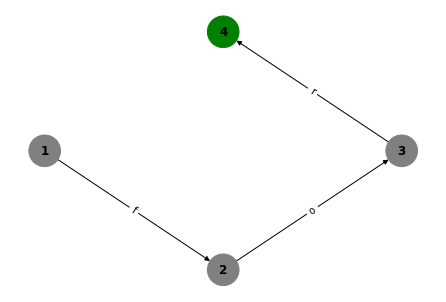

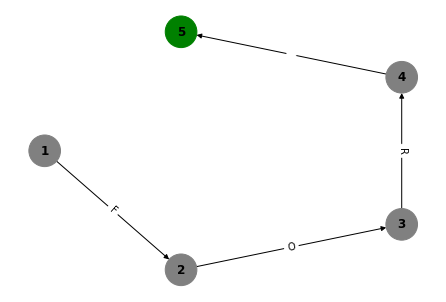

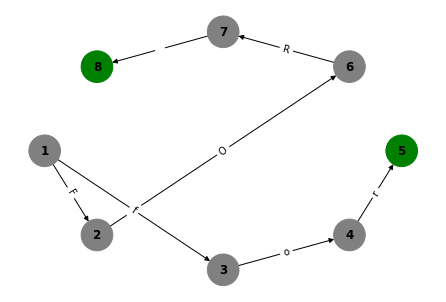

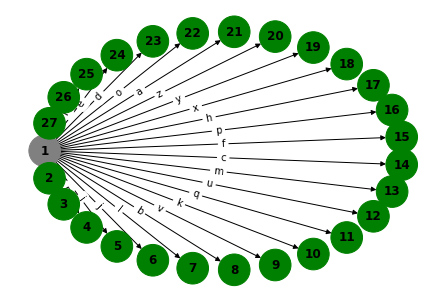

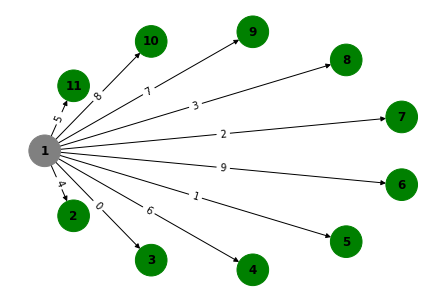

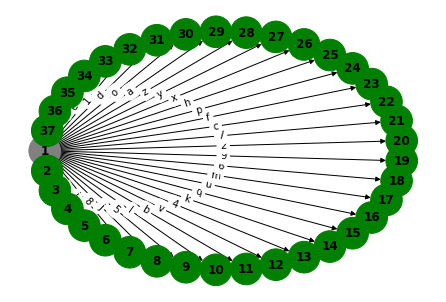

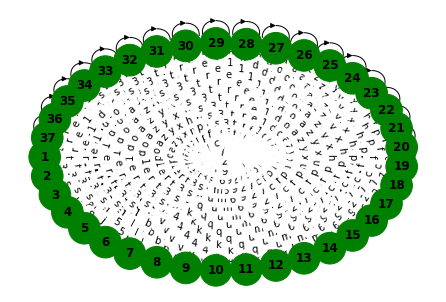

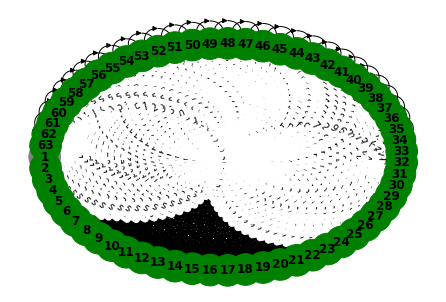

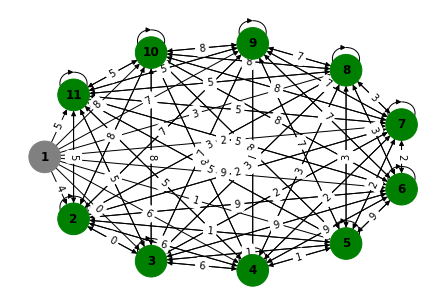

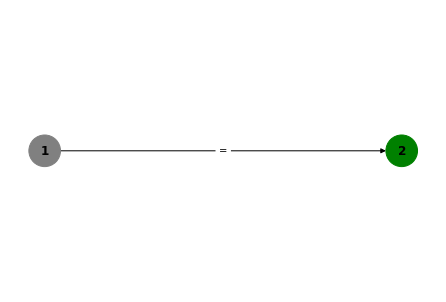

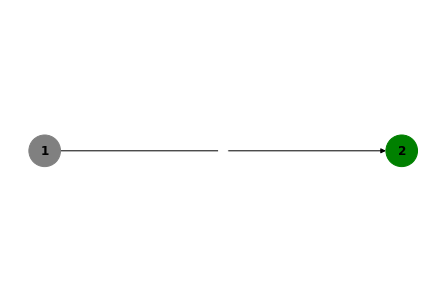

In [29]:
for automata in automatas:
  draw_automata(automata)

### Reconocimiento de tokens
Luego se reconocen los tokens en el archivo `user_input.txt`

In [31]:
input_file = open('user_input.txt','r')
file_lines = input_file.readlines()
exs = list()
# elimina tokens auxiliares
for i in range(len(tokens)):
  if not tokens[i].isupper():
    exs.append(execution(tokens[i],automatas[i]))

for line in file_lines:
  for i in range(len(line)):
    for ex in exs:
      if(ex.execute(line[i],i)):
        if(i==len(line)-1 or not ex.look(line[i+1])):
          print(f"Tipo de token: {ex.token} - Posición inicial:{ex.start_index+1} - Posición final:{ex.end_index+1} - valor: ‘{ex.s}’")
          ex.reset()

Tipo de token: loop - Posición inicial:1 - Posición final:3 - valor: ‘for’
Tipo de token: identifier - Posición inicial:1 - Posición final:3 - valor: ‘for’
Tipo de token: space - Posición inicial:4 - Posición final:4 - valor: ‘ ’
Tipo de token: identifier - Posición inicial:5 - Posición final:5 - valor: ‘a’
Tipo de token: space - Posición inicial:6 - Posición final:6 - valor: ‘ ’
Tipo de token: equal - Posición inicial:7 - Posición final:7 - valor: ‘=’
Tipo de token: space - Posición inicial:8 - Posición final:8 - valor: ‘ ’
Tipo de token: digito - Posición inicial:9 - Posición final:9 - valor: ‘1’


# Parte B
1. - `KEY`: Solo cadenas de numeros y letras que empiezan y terminan por `"`
  - `VALUE`: Puede ser un numero o una cadena que empieza y termina por `"`
2.  - `KEY` -> `"[[0-9]|[a-z]]+"`
  - `VALUE` -> `[0-9]+ | "[a-z]+"` 
  

In [33]:
tokens = list()
my_nfas = list()
automatas = list()
input_file = open('json_tokens.txt','r')
file_lines = input_file.readlines()
for line in file_lines:
  line = line.strip("\n")
  token, regex = line.split(" -> ")
  new_NFA = NFA(regex)
  my_nfas.append(new_NFA)
  new_DFA = DFA(new_NFA) 
  tokens.append(token)
  automatas.append(new_DFA)



In [34]:
input_file = open('json_input.txt','r')
file_lines = input_file.readlines()
exs = list()
# elimina tokens auxiliares
for i in range(len(tokens)):
  if not tokens[i].isupper():
    exs.append(execution(tokens[i],automatas[i]))

for line in file_lines:
  for i in range(len(line)):
    for ex in exs:
      if(ex.execute(line[i],i)):
        if(i==len(line)-1 or not ex.look(line[i+1])):
          print(f"Tipo de token: {ex.token} - Posición inicial:{ex.start_index} - Posición final:{ex.end_index} - valor: ‘{ex.s}’")
          ex.reset()

Tipo de token: key - Posición inicial:1 - Posición final:8 - valor: ‘"nombre"’
Tipo de token: value - Posición inicial:1 - Posición final:8 - valor: ‘"nombre"’
Tipo de token: key - Posición inicial:10 - Posición final:16 - valor: ‘"jason"’
Tipo de token: value - Posición inicial:10 - Posición final:16 - valor: ‘"jason"’
Tipo de token: key - Posición inicial:18 - Posición final:27 - valor: ‘"apellido"’
Tipo de token: value - Posición inicial:18 - Posición final:27 - valor: ‘"apellido"’
Tipo de token: key - Posición inicial:29 - Posición final:36 - valor: ‘"derulo"’
Tipo de token: value - Posición inicial:29 - Posición final:36 - valor: ‘"derulo"’
Tipo de token: key - Posición inicial:38 - Posición final:43 - valor: ‘"edad"’
Tipo de token: value - Posición inicial:38 - Posición final:43 - valor: ‘"edad"’
Tipo de token: value - Posición inicial:45 - Posición final:46 - valor: ‘33’


# Parte C
- **Tokenización en subpalabras**: Es la estrategia híbrida entre tokenización con palabras y caracteres. Les asignamos un identificador a las palabras más frecuentes y las palabras raras las descomponemos a partir de palabras más frecuentes y las identificamos en función de estas. Por ejemplo: 
  - **casa** es una palabra frecuente, supongamos que la identificamos con el número 100,
  - y para las palabras que representan plural como "**s**" le asignamos el número 200. 
  - Luego **casas**, la identificamos como 100 y 200

- **Tokenización BPE:** Consiste en identificar que par de bits van frecuentemente unidos, y hacer un cambio de variable
Por ejemplo: Tomemos las palabras claves de Python `int` e `in`. Podriamos reemplazar `in` por `x` y queda `xt` y `x`. 
- **Algoritmo Unigram:** Es un algoritmo de tokenización por subpalabras basado en el modelo de lenguaje, Unigrama. Consiste en 

  1) Asignar a cada símbolo en el vocabulario inicial una probabilidad. La cual es:
  $\frac{\text{número de veces que aparece en el texto}}{\text{total de palabras en el texto}}$

  2) Luego, se calcula la pérdida de quitar un símbolo del vocabulario
  3) Se quitan los símbolos cuya pérdida es la menor

- Los parsers **basados en el lenguaje natural**, nos permiten extraer un significado más comprensible al humano a diferencia de las anteriores estrategias vistas. Pero un problema que sí tienen estos tipos de parsers es lidiar con la ambigüedad del lenguaje humano.